In [16]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import gdoom

env = gym.make("doom_scenario2_96-v0")

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

C:\Users\Frederik\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Doom> Loading level: C:\Users\Frederik\Anaconda3\lib\site-packages\vizdoom/scenarios/defend_the_center.cfg


In [17]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [18]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

def get_screen(x):
    x = np.array(x)
    screen = x.transpose((2,0,1))

    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    return resize(screen).unsqueeze(0).to(device)


In [19]:
p = 0.2
end_out = 64
num_frames = 4


class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(num_frames, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, end_out, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(end_out)
        self.dropout = nn.Dropout(p)

        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * end_out
        
        self.lstm = nn.LSTM(input_size = convw * convh,
                                  hidden_size = convw * convh)
        
        self.head = nn.Linear(linear_input_size, outputs)

    def forward(self, x):
        # 3 times conv layers with batchnorm, dropout and Relu activation
       # print(x.size())
        x = F.relu(self.bn1(self.conv1(x)))
       # print(x.size())
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x)))
       # print(x.size())
        
        x = self.dropout(x)
        x = F.relu(self.bn3(self.conv3(x)))
       # print(x.size())
        x = self.dropout(x)
        
       # print("4 " + str(x.size()))
        #print((self.head(x.view(x.size(0), -1))).size())
        # LSTM layer
        x = x.view(x.size()[0],x.size()[1],x.size()[2]*x.size()[3]) 
       # print(x.size())
        x, h_t = self.lstm(x)
        
        
        return self.head(x.view(x.size()[0], x.size()[1]*x.size()[2]))

In [20]:
def save_modules(PATH):
    #PATH = 'C:/Users/Frederik/Desktop/Gdoom/Model/save.tar'
    torch.save({
                'model': target_net,
                'model_state_dict': target_net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_list,
                'reward': reward_list
                }, PATH)

In [21]:
BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 1000000
TARGET_UPDATE = 5

init_screen = get_screen(env.reset())
_, _, screen_height, screen_width = init_screen.shape

n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters(),lr=0.001,weight_decay=0.00001)
memory = ReplayMemory(1000000)

steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


In [22]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    
    ## Brug MSQ Error i stedet maybe
    # Compute Huber loss
    loss = F.l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    loss_list.append(float(loss))
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [23]:
num_episodes = 101
reward_list = list()
loss_list = list()
reward_batch = list()
final_info = list()

#PATH = 'C:/Users/marcv/Desktop/DoomSave/saveV2.tar'
PATH = 'C:/Users/Frederik/Desktop/Gdoom/Model/saveV2.tar'
#checkpoint = torch.load(PATH)
#target_net.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#reward_list = checkpoint['reward']
#loss_list = checkpoint['loss']


for i_episode in range(num_episodes):
    frame = env.reset()
    last_screen = get_screen(frame)
    current_screen = get_screen(frame)
    state = current_screen
    acc_reward = 0
  #  print(state)
    for t in count():
        action = select_action(state)
        #
        frame, reward, done, info = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        acc_reward += reward
      # print(float(reward))

        last_screen = current_screen
        current_screen = get_screen(frame)
        if not done:
            next_state = current_screen
        else:
            next_state = None

        memory.push(state, action, next_state, reward)

        state = next_state

        optimize_model()
        if done:
            episode_durations.append(t + 1)
            final_info.append(info)
            break
    reward_list.append(float(acc_reward))
    
    if i_episode % TARGET_UPDATE == 0:
        #print(i_episode)
        target_net.load_state_dict(policy_net.state_dict())
    if i_episode/10 % TARGET_UPDATE == 0:
        if i_episode != 0:
            reward_batch.append(sum(reward_list[-TARGET_UPDATE*10:])/(TARGET_UPDATE*10))
        print("COMPLETE! " + ", Episode: " + str(i_episode) + ", Cumm. Reward: " + str(reward_batch[-1:]))
    save_modules(PATH)
        
print('Complete')
env.close()

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
COMPLETE! , Episode: 0, Cumm. Reward: []
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])


KeyboardInterrupt: 

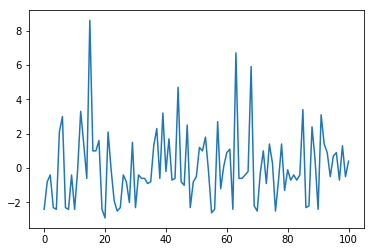

In [17]:
plt.plot(reward_list)

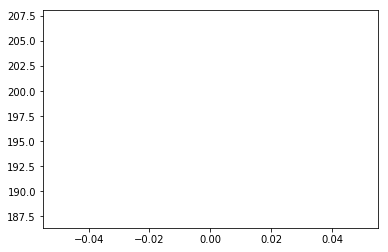

In [58]:
plt.plot(reward_batch)

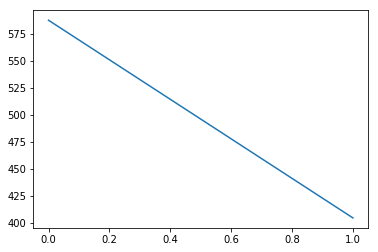

In [149]:
loss_list = np.array(loss_list)
avg_loss_list = np.mean(loss_list[:(len(loss_list)//1000)*1000].reshape(-1,1000), axis=1)
plt.plot(avg_loss_list)

In [68]:
print(env.get_keys_to_action)

<bound method GDoomEnv.get_keys_to_action of <gdoom.gdoom_env.WGDoomEnv object at 0x0000020D25491780>>
